In [298]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import accuracy_score

### load dataset

#### first dataset (binary classification)

In [299]:
data = pd.read_csv('diabetes.csv')
del data['SkinThickness']

data.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,0,33.6,0.627,50,1
1,1,85,66,0,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,94,28.1,0.167,21,0
4,0,137,40,168,43.1,2.288,33,1


### preprocessing the data 

#### check for outliears

<AxesSubplot: >

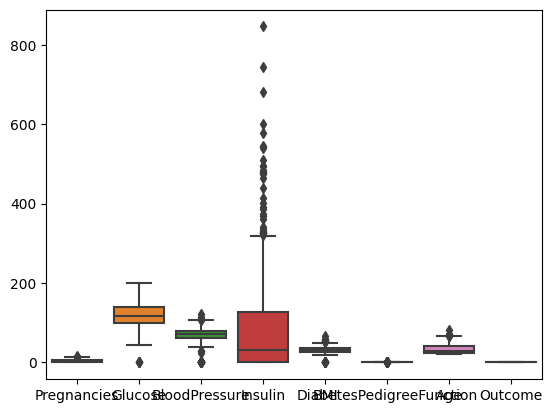

In [300]:
sns.boxplot(data=data)  

In [301]:
def find_outliers(col):
    q1 = col.quantile(.25)
    q3 = col.quantile(.75)
    IQR = q3 - q1
    ll = q1 - (1.5*IQR)
    ul = q3 + (1.5*IQR)
    upper_outliers = col[col > ul].index.tolist()
    lower_outliers = col[col < ll].index.tolist()
    bad_indices = list(set(upper_outliers + lower_outliers))
    return(bad_indices,lower_outliers,upper_outliers)

bad_indexes = []
for col in data.columns:
    if data[col].dtype in ["int64","float64"]:
        BI,lower,upper = find_outliers(data[col])
        bad_indexes.append(BI)
        data.drop(upper, inplace = True)
        data.drop(lower, inplace = True)
         

bad_indexes = set(list(np.concatenate(bad_indexes).flat))
print(len(bad_indexes))
data.head()


128


,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,0,33.6,0.627,50,1
1,1,85,66,0,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,94,28.1,0.167,21,0
5,5,116,74,0,25.6,0.201,30,0


#### normalize the data 

In [302]:
data = np.array(data)
x = data[:, 0:6]
y = data[:,7]
y = y.reshape(-1,1)
normalized_data = preprocessing.normalize(x)

<AxesSubplot: >

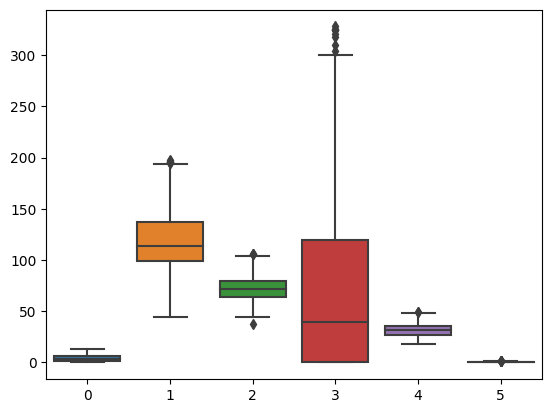

In [303]:
sns.boxplot(data=x)

#### split the data

In [304]:
x_train, x_test,y_train, y_test = train_test_split(normalized_data,y ,random_state=104, train_size=0.8,test_size=0.2, shuffle=True)

## NN model

In [305]:
def sigmoid(x, derivate=False):
    if derivate:
        return(np.exp(-x))/((np.exp(-x)+1)**2)
    else:
        return (1/(np.exp(-x)+1))    

def softmax(x,derivate = False):
    exp_element=np.exp(x-x.max())
    if derivate:
        return (exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0)))    
    else:
        return (exp_element/np.sum(exp_element,axis=0))

def init(x,y):
    layer=np.random.uniform(size=(x,y)) #/ np.sqrt(x*y)
    return layer

def mean_squared_error(y, y_pred,derivate = False):
    if derivate:
        return(y_pred - y)
    else:
        return sum((y-y_pred)**2) / len(y)

def cross_entropy(y,y_pre):
    loss=-np.sum(y*np.log(y_pre))
    return loss/float(y_pre.shape[0])

w1 = init(6,3)
w2 = init(3,1)

def forward_backward_pass(x,y,lr):
    # forward
    Z1 = x.dot(w1) 
    A1 = sigmoid(Z1)
    Z2 =A1.dot(w2) 
    A2 = sigmoid(Z2)
    
    #backward
    # output layer
    
    for i in range(y.shape[0]):
        delta = (y[i]-A2[i]) * sigmoid(A2[i],True)
        w2_change_rate = lr * delta * A1[i]

    w2_change_rate = w2_change_rate.reshape(3,1)
    w2_new = w2 - w2_change_rate
    
    # hidden layer
    for i in range(y.shape[0]):
        delta_hidden = np.dot(delta , w2_new.T)  * sigmoid(A1[i],True)
        delta_hidden = delta_hidden.reshape(3,1)
        x1 = x[i].reshape(1,6)
        w1_change_rate = lr * np.dot(delta_hidden ,x1)
    
    w1_new = w1 - w1_change_rate.T
    
    return(A2,w1_new,w2_new)

### fit model on the frist data 

In [306]:
epochs=300
lr=0.001
batch=100

losses,accuracies,test_accuracies=[],[],[]

for i in range(epochs):
    
    sample=np.random.randint(0,x_train.shape[0],size=(batch))
    x=x_train[sample]
    y=y_train[sample]
 

    out,w1_updated,w2_updated =forward_backward_pass(x,y,lr)
  
    category=np.argmax(out,axis=1)
    accuracy=(category==y).mean()
    accuracies.append(accuracy)
    
    train_loss= cross_entropy(y,out)
    train_loss = train_loss.mean()
    losses.append(train_loss.item())
 
    
    y_pred=np.argmax(softmax(sigmoid(x_test.dot(w1_updated)).dot(w2_updated)),axis=1)
    test_acc=(y_pred==y_test).mean()
    test_accuracies.append(test_acc.item())
    
    y_pred2 = (softmax(sigmoid(x_test.dot(w1_updated)).dot(w2_updated)))
    test_loss = cross_entropy(y_test,y_pred2)
    test_loss = test_loss.mean()
    
    
    print(f'For {i}th epoch: train accuracy: {accuracy*100:.3f} ')
    print(f'For {i}th epoch: test accuracy: {test_acc*100:.3f} ')
    print(f'For {i}th epoch: train loss: {train_loss:.3f} ')
    print(f'For {i}th epoch: test loss: {test_loss:.3f} ')

    

For 0th epoch: train accuracy: 58.000 
For 0th epoch: test accuracy: 72.656 
For 0th epoch: train loss: 0.200 
For 0th epoch: test loss: 1.327 
For 1th epoch: train accuracy: 71.000 
For 1th epoch: test accuracy: 72.656 
For 1th epoch: train loss: 0.138 
For 1th epoch: test loss: 1.327 
For 2th epoch: train accuracy: 64.000 
For 2th epoch: test accuracy: 72.656 
For 2th epoch: train loss: 0.171 
For 2th epoch: test loss: 1.327 
For 3th epoch: train accuracy: 70.000 
For 3th epoch: test accuracy: 72.656 
For 3th epoch: train loss: 0.143 
For 3th epoch: test loss: 1.327 
For 4th epoch: train accuracy: 73.000 
For 4th epoch: test accuracy: 72.656 
For 4th epoch: train loss: 0.128 
For 4th epoch: test loss: 1.327 
For 5th epoch: train accuracy: 68.000 
For 5th epoch: test accuracy: 72.656 
For 5th epoch: train loss: 0.153 
For 5th epoch: test loss: 1.327 
For 6th epoch: train accuracy: 77.000 
For 6th epoch: test accuracy: 72.656 
For 6th epoch: train loss: 0.109 
For 6th epoch: test loss:

In [307]:
precision = precision_score(y_test, y_pred, average='binary')

ecall = recall_score(y_test, y_pred, average='binary')

f1_score = f1_score(y_test, y_pred, average='binary')


c:\Users\yasme\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
